In [1]:
# Import  all required modules and functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
sns.set_style("darkgrid")

# Diable warnings
import warnings
warnings.filterwarnings('ignore')
# Imputing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
# Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
# Ordinal
from sklearn.preprocessing import OrdinalEncoder
# OneHot
from sklearn.preprocessing import OneHotEncoder
# Bins
from sklearn.preprocessing import KBinsDiscretizer
#RBF
from sklearn.gaussian_process import GaussianProcessClassifier
# Customized transformer
from sklearn.preprocessing import FunctionTransformer
# Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
# Column transformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
# Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
# Train test split
from sklearn.model_selection import train_test_split
#Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
# Roc-curve (AUC)
from sklearn.metrics import plot_roc_curve, roc_curve, auc
# Cross-validation
from sklearn.model_selection import cross_val_score
# Confusin matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Different scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_log_error, make_scorer, r2_score
# Hyperparameteroptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

In [2]:
# Some settings for plotting
sns.set_theme(style="whitegrid", font_scale=1.5)

# Prework

## Import data

In [3]:
df_bike = pd.read_csv('../data/train.csv', index_col=0, parse_dates=True)

In [4]:
df_bike.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [6]:
df_bike.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Define some global functions

In [7]:
# Define rmsle function for evaluation
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [8]:
# Transform rmsle fucntion into scorer 
rmsle_scorer = make_scorer(score_func=rmsle, greater_is_better=False)

In [9]:
# Function to print out results of the hyperparameter optimization
def print_results(cv_h, show_all = False):
    print('Best:')
    print(round(cv_h.best_score_, 3), ' for ', cv_h.best_params_)
    if show_all:
        print('All:')
        for mean, params in zip(cv_h.cv_results_['mean_test_score'], 
                                cv_h.cv_results_['params']):
                print('{}  for {}'.format(round(mean, 3), params))

# Add additional features

## Add time related features

In [10]:
df_bike = df_bike.reset_index()

In [11]:
# Year
df_bike['year'] = df_bike['datetime'].apply(lambda x: x.year)

In [12]:
# Month
df_bike['month'] = df_bike['datetime'].apply(lambda x: x.month)

In [13]:
# Day of the week
df_bike['day'] = df_bike['datetime'].apply(lambda x: x.isoweekday())

In [14]:
# Hour within day
df_bike['hour'] = df_bike['datetime'].apply(lambda x: x.hour)

In [15]:
df_bike = df_bike.set_index('datetime')

In [16]:
# Open question: why is this not working
#df_bike['hour'] = df_bike.reset_index().loc[:,'datetime'].apply(lambda x: x.hour)
#df_bike.head()

## Add 'rolling' mean/min/max features

In [17]:
# mean of temp of previous 3 and 12 hours
df_bike['temp_mean_3'] = df_bike['temp'].rolling(3).mean().fillna(method='bfill')
df_bike['temp_mean_12'] = df_bike['temp'].rolling(12).mean().fillna(method='bfill')

In [18]:
# max of weather of previous 3 and 12 hours
df_bike['weather_max_3'] = df_bike['weather'].rolling(3).max().fillna(method='bfill')
df_bike['weather_max_12'] = df_bike['weather'].rolling(12).max().fillna(method='bfill')

In [19]:
# min of weather of previous 3 and 12 hours
df_bike['weather_min_3'] = df_bike['weather'].rolling(3).min().fillna(method='bfill')
df_bike['weather_min_12'] = df_bike['weather'].rolling(12).min().fillna(method='bfill')

In [20]:
# mean of wind of previous 3 and 12 hours
df_bike['windspeed_mean_3'] = df_bike['windspeed'].rolling(3).mean().fillna(method='bfill')
df_bike['windspeed_mean_12'] = df_bike['windspeed'].rolling(12).mean().fillna(method='bfill')

# Explorative data analysis

In [21]:
df_bike.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,day,hour,temp_mean_3,temp_mean_12,weather_max_3,weather_max_12,weather_min_3,weather_min_12,windspeed_mean_3,windspeed_mean_12
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,...,6,0,9.293333,10.66,1.0,2.0,1.0,1.0,0.0,3.500192
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,...,6,1,9.293333,10.66,1.0,2.0,1.0,1.0,0.0,3.500192
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,...,6,2,9.293333,10.66,1.0,2.0,1.0,1.0,0.0,3.500192
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,...,6,3,9.293333,10.66,1.0,2.0,1.0,1.0,0.0,3.500192
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,...,6,4,9.566667,10.66,1.0,2.0,1.0,1.0,0.0,3.500192


## Check correlation of features

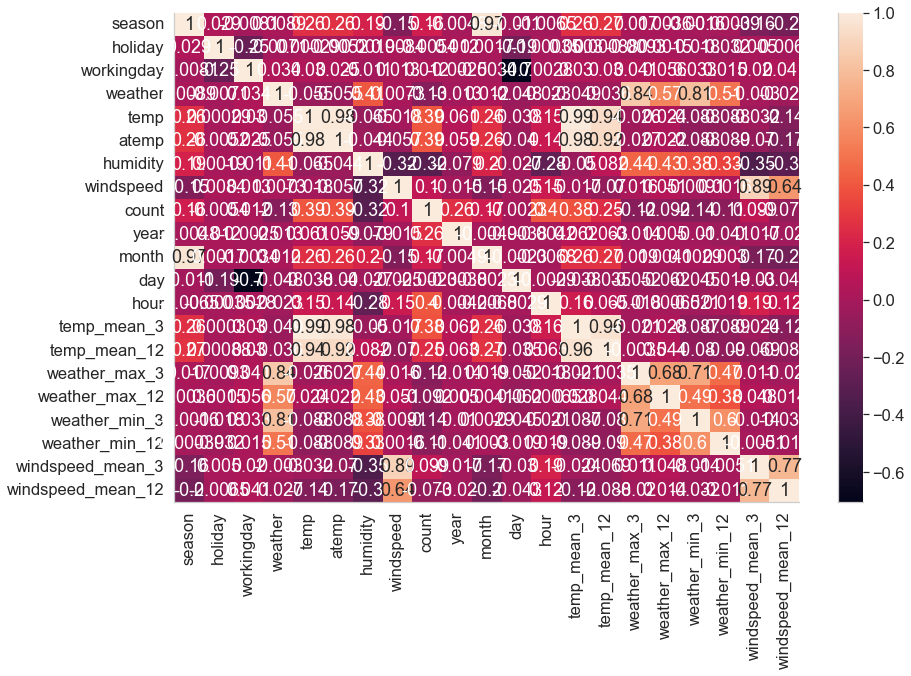

In [22]:
plt.figure(figsize=(14,9))
sns.heatmap(df_bike.drop(['casual', 'registered'], axis = 1).corr(), annot=True)
sns.despine()

__We can drop some features from the data set:__
* `'workingday'`: Is an aggreagtion of 'holiday' and 'day'
* `'season'`: Is strongley correlated to 'month'
* `'atemp'`: Is strongly correlated to temperature
* `xxx_mean/min/max_3`: Overall these values strongly correlated, will only keep mean_12 features

In [23]:
# Drop 'workingday' and 'season'
df_bike = df_bike.drop(['workingday', 'season', 'atemp', 
                        'temp_mean_3', 'weather_min_3', 'weather_max_3',
                        'windspeed_mean_3'], 
                       axis = 1)

## Analyze "means of counts" per time

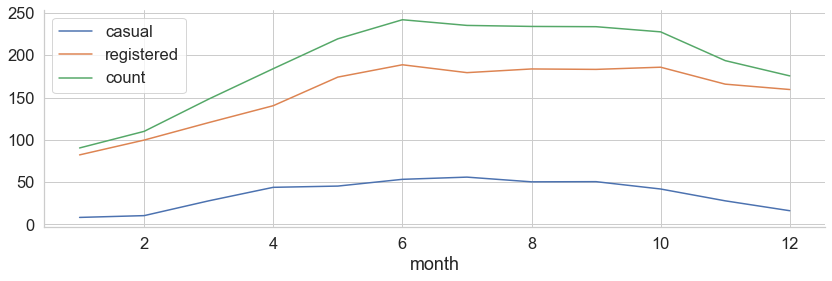

In [24]:
# Means of count per month 
df_bike.groupby('month')[['casual', 'registered', 'count']].mean().plot(figsize=(14,4))
sns.despine()

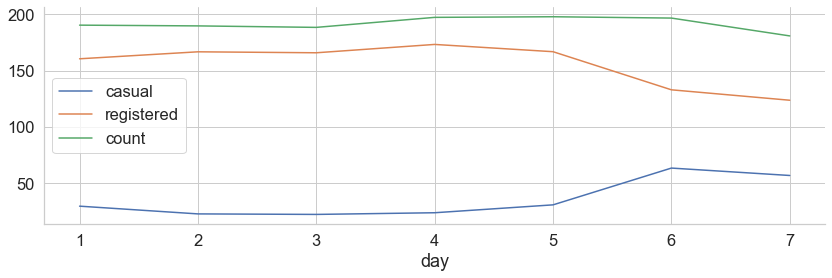

In [25]:
# Means of count per day 
df_bike.groupby('day')[['casual', 'registered', 'count']].mean().plot(figsize=(14,4))
sns.despine()

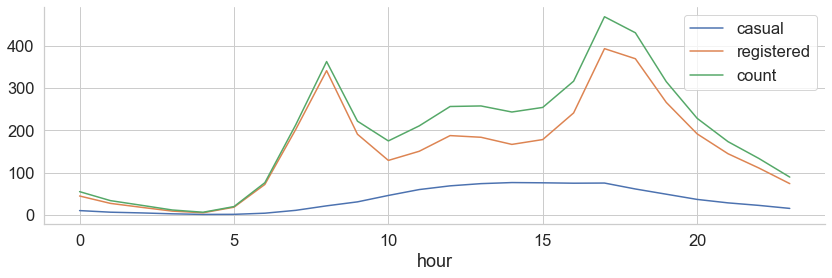

In [26]:
# Means of count per hour
df_bike.groupby('hour')[['casual', 'registered', 'count']].mean().plot(figsize=(14,4))
sns.despine()

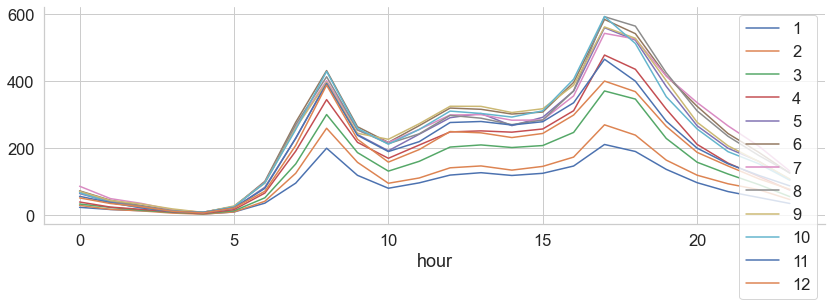

In [27]:
# Means of count per day over months
data = pd.DataFrame()
for month in range(1,13):
    data[month] = df_bike[df_bike['month'] == month].groupby('hour')['count'].mean()
   
data.plot(figsize=(14,4))
sns.despine()

## Analyze impact of selected variables on count

### Weather / ambient conditions

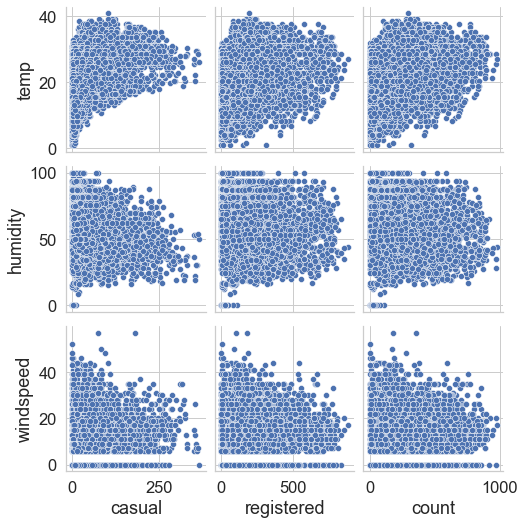

In [28]:
sns.pairplot(data = df_bike,
             x_vars = ['casual', 'registered', 'count'],
             y_vars = ['temp', 'humidity', 'windspeed'])
sns.despine()

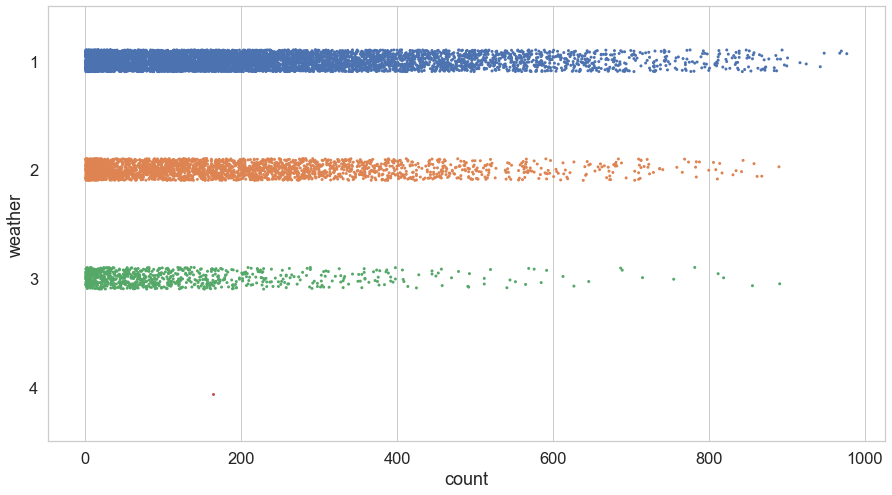

In [29]:
# Counts depending on 'weather' (1/2)
plt.figure(figsize=(15,8))
ax = sns.stripplot(x=df_bike['count'], y=df_bike['weather'].astype(str), size = 3)
#ax.set(ylabel="")
plt.show()

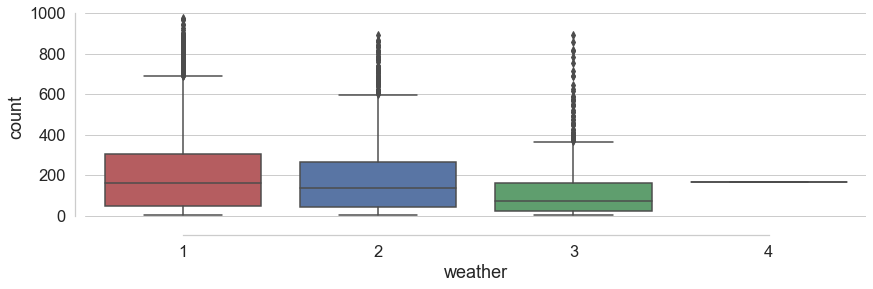

In [30]:
# Counts depending on 'weather' (2/2)
# 1 =. good -> 4 = very bad
plt.figure(figsize=(14,4))
sns.boxplot(data = df_bike, 
            x='weather', y='count',
            palette=['r', 'b', 'g', 'y'])
sns.despine(offset=10, trim=True)

### Other variables

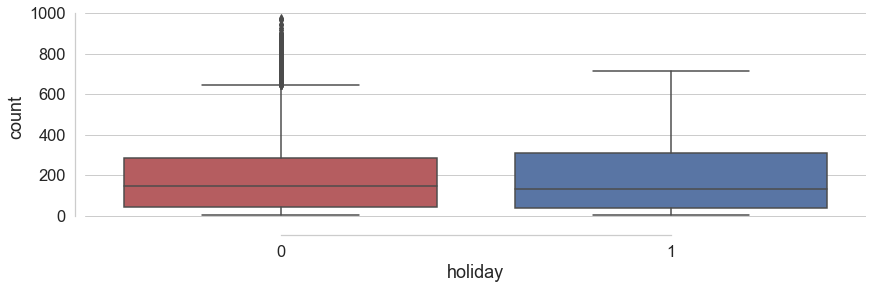

In [31]:
# Counts depending on holiday
# 1 = holiday
plt.figure(figsize=(14,4))
sns.boxplot(data = df_bike, 
            x='holiday', y='count',
            palette=['r', 'b', 'g', 'y'])
sns.despine(offset=10, trim=True)

# Linear regression

## Split data

In [32]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y = df_bike['count']

In [33]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size = 0.2, 
                                                            random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708,), (2178,))

## Engineer features

_Numeric columns to be scaled, categorical columns to be onehot encoded, use of polynomial features_

### Define pipelines

In [34]:
# Scaling for numeric variables
num_pipe = make_pipeline(
    MinMaxScaler()
)

In [35]:
# One_hot_encoding for categorical variables
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown = 'ignore')
)

In [36]:
# Prepare tables for RBF encoding - not implemented
def rbf(x, width, mean):
    """calculates a single RBF peak"""
    return np.exp(-(x - mean)**2 / (2 * width))

def rbf_transform(df, freq, width):
    """creates repeating seasonal RBF peaks"""
    n_values = df.shape[0]
    x = np.arange(n_values)
    for i in range(0, freq):
        df[f'rbf_{i}'] = 0
        for j in range(-freq, n_values+freq, freq):
            df[f'rbf_{i}'] += rbf(x, width, j + i)
    return df

# Create tabel for month and hour encoding
df_month = rbf_transform(pd.DataFrame(range(12)), 12, 5)  
df_hour = rbf_transform(pd.DataFrame(range(24)), 24, 5) 

In [37]:
# Create rbf encoding for months - not implemented
def rbf_month(df): 
    df = pd.DataFrame(df)     
    selection = range(1,13) # range can be adjusted - range(1,13) is similar to onehot-encoding
    
    rbf_series = None
    
    for i in selection: 
        if i == 1:
            rbf_series = df.iloc[:, 0].apply(lambda x: df_month.iloc[x-1, i])
        else:
            rbf_series_new = df.iloc[:, 0].apply(lambda x: df_month.iloc[x-1, i])
            rbf_series = pd.concat([rbf_series, rbf_series_new], axis = 1)
    
    return rbf_series.values.reshape(-1, len(selection))
    
rbf_month_pipe = make_pipeline(
    FunctionTransformer(rbf_month)
)

# Test
#rbf_month_pipe.fit_transform(pd.DataFrame([12]))

In [38]:
# Create rbf encoding for hours - not implemented
def rbf_hour(df): 
    df = pd.DataFrame(df)     
    selection = range(1, 25)
    
    rbf_series = None
    
    for i in selection: # range can be adjusted - full range similar to onehot-encoding
        if i == 1:
            rbf_series = df.iloc[:, 0].apply(lambda x: df_hour.iloc[x, i])
        else:
            rbf_series_new = df.iloc[:, 0].apply(lambda x: df_hour.iloc[x, i])
            rbf_series = pd.concat([rbf_series, rbf_series_new], axis = 1)
    
    return rbf_series.values.reshape(-1, len(selection))
    
rbf_hour_pipe = make_pipeline(
    FunctionTransformer(rbf_hour)
)

# Test
#rbf_hour_pipe.fit_transform(df_bike[['hour']])
#pd.DataFrame(rbf_hour_pipe.fit_transform(pd.DataFrame([1, 7, 23])))

In [39]:
# How to implement customized functions

'''

def function(df):
    
    # save passed data as dataframe
    df = pd.DataFrame(df)
    
    # function 1
    helper_list = df.iloc[:, 0].apply(lambda x: ...)
    
    # function 2
    ...
    
    # Concat both results and send as back as numpy array        
    merged_data = pd.concat([helper_list1, helper_list2, ...], axis = 1)
    
    # Write list of column names ('column names' should be global variable)
    column_names.append('helper1', 'helper2', ...)
    
    return merged_data.values.reshape(-1, # of functions)

 
pipeline = make_pipeline(
    FunctionTransformer(function)
)


''';


### Summarize in column transformer

In [40]:
df_bike.head(1)

,holiday,weather,temp,humidity,windspeed,casual,registered,count,year,month,day,hour,temp_mean_12,weather_max_12,weather_min_12,windspeed_mean_12
datetime,,,,,,,,,,,,,,,,
2011-01-01,0,1,9.84,81,0.0,3,13,16,2011,1,6,0,10.66,2.0,1.0,3.500192


In [41]:
# Defining the "preprocessor"
feature_transform = ColumnTransformer([
    ('do_nothing', 'passthrough', ['holiday']), 
    ('one_hot_encoding', cat_pipe, ['weather', 'weather_max_12', 'weather_min_12', 
                                    'year', 'month', 'day', 'hour']),
    #('rbf_month_encoding', rbf_month_pipe, ['month']),
    #('rbf_hour_encoding', rbf_hour_pipe, ['hour']),
    ('num_scaling', num_pipe, ['temp', 'temp_mean_12', 'humidity', 'windspeed', 'windspeed_mean_12'])
])

In [42]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        #print('\n\ntransformer: ', transformer_in_columns[0])
        
        raw_col_name = list(transformer_in_columns[2])
        
        if isinstance(transformer_in_columns[1], Pipeline): 
            # if pipeline, get the last transformer
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
            
        try:
          if isinstance(transformer, OneHotEncoder):
            names = list(transformer.get_feature_names(raw_col_name))
            
          elif isinstance(transformer, SimpleImputer) and transformer.add_indicator:
            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [raw_col_name[idx] + '_missing_flag' for idx in missing_indicator_indices]

            names = raw_col_name + missing_indicators
            
          else:
            names = list(transformer.get_feature_names())
          
        except AttributeError as error:
          names = raw_col_name
        
        #print(names)    
        
        col_name.extend(names)
            
    return col_name

In [43]:
# This only works after the model has been trained! (function not availble when working with Anaconda)
#feature_columns = get_column_names_from_ColumnTransformer(feature_transform)
#feature_columns

## Create regression model

In [44]:
# Create regression model
rgr_ln = Pipeline(steps=[
            ('preprocessor', feature_transform),
            ('poly_features', PolynomialFeatures(degree=2, 
                                                 include_bias=False, 
                                                 interaction_only=False)),
            ('m_ln', LinearRegression())
])

# Implement target transformation
rgr_ln_t = TransformedTargetRegressor(regressor=rgr_ln, func=np.log1p, inverse_func=np.expm1)

In [45]:
# Impact of transformation on data shape/size
import scipy.sparse

X_train_1 = pd.DataFrame.sparse.from_spmatrix(feature_transform.fit_transform(X_train))
poly_transform = PolynomialFeatures(degree=2, 
                                    include_bias=False, 
                                    interaction_only=True)
X_train_2 = pd.DataFrame.sparse.from_spmatrix(poly_transform.fit_transform(X_train_1))

print('Before transformation:    ', X_train.shape)
print('After feature_transform:  ', X_train_1.shape)
print('After polynomialfeatures: ', X_train_2.shape)

Before transformation:     (8708, 13)
After feature_transform:   (8708, 62)
After polynomialfeatures:  (8708, 1953)


In [46]:
#rgr_ln_t.fit(X_train, y_train);
rgr_ln_t.fit(X_train, y_train);

## Evaluate regression model

_2 metrics used (R2 & RMSLE), RMSLE used for Kaggle competition_

### Using R2

In [47]:
r2_train = round(rgr_ln_t.score(X_train, y_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.956


In [48]:
r2_test = round(rgr_ln_t.score(X_test, y_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.947


In [49]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_ln_t, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
cross_val_r2

array([0.93750671, 0.93559236, 0.93202331, 0.94741927, 0.93776716])

In [50]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.938

### Using RMSLE

In [51]:
#Get predictions for train and test dataset
y_pred_train = rgr_ln_t.predict(X_train)
y_pred_test = rgr_ln_t.predict(X_test)

In [52]:
# RMSLE for train set
RMSLE_train = round(rmsle(y_train, y_pred_train), 3)
print(f'RMSLE for train dataset: {RMSLE_train}')

RMSLE for train dataset: 0.253


In [53]:
# RMSLE for train set
RMSLE_test = round(rmsle(y_test, y_pred_test), 3)
print(f'RMSLE for test dataset: {RMSLE_test}')

RMSLE for test dataset: 0.289


In [54]:
# Cross-validation with RMSLE as scorer (cv = shs -> random sampling)
shs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_rmsle = -1 * cross_val_score(rgr_ln_t, X_train, y_train, 
                                       cv=shs, scoring=rmsle_scorer,
                                       n_jobs=-1)#, error_score="raise")
cross_val_rmsle

array([0.33424862, 0.30380169, 0.32689449, 0.29260256, 0.30836338])

In [55]:
# Mean RMSLE from cross-validation
round(cross_val_rmsle.mean(), 3)

0.313

In [56]:
# Random cross-validation with RMSLE as scorer (for comparison with 2 modell approach)

# Make sure to use original train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rmsle_list = []

for i in [12, 24, 44, 233, 53]:
    
    #Split the data set
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
    
    # Train the 2 models
    rgr_ln_t.fit(X_trn, y_trn)
    
    # Predict outcomes separately
    y_pred_tst = rgr_ln_t.predict(X_tst)
    
    # Calculate RMSLE score
    rmsle_i = rmsle(y_tst, y_pred_tst)
    
    # Save result
    rmsle_list.append(rmsle_i)
    
# Print results
print('List of results: ', [round(i, 3) for i in rmsle_list])
print('Mean value: ', round(np.mean(rmsle_list), 3))

List of results:  [0.308, 0.311, 0.295, 0.301, 0.297]
Mean value:  0.302


### Check predictions vs. true values

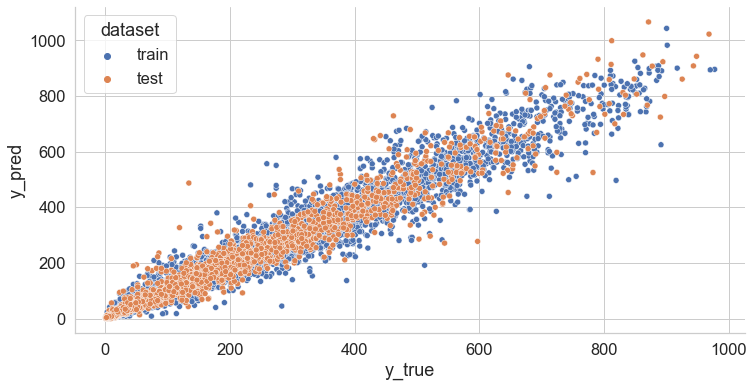

In [57]:
# Draw scatterplot of predictions vs. true values
df_res = pd.DataFrame(y_train)
df_res['y_pred']=y_pred_train
df_res['dataset']='train'
df_res.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res2 = pd.DataFrame(y_test)
df_res2['y_pred']=y_pred_test
df_res2['dataset']='test'
df_res2.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res = pd.concat([df_res, df_res2], ignore_index=True, sort=False)

#sns.relplot(x='y_true', y='y_pred', data=df_res, col='dataset', hue='dataset',height = 4)
plt.figure(figsize=(12,6))
sns.scatterplot(x='y_true', y='y_pred', hue='dataset', data=df_res)
sns.despine()


# Poisson regression

## Split data

In [58]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y = df_bike['count']

In [59]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708,), (2178,))

## Engineer features

_Same feature engineering as for linear regression_

## Create regression model

In [60]:
rgr_pos = Pipeline(steps=[
    ('preprocessor', feature_transform),
    ('poly_features', PolynomialFeatures(degree=2, 
                                         include_bias=False,
                                         interaction_only=False)),
    #('MaxAbsScaler', MaxAbsScaler()),
    ('m_pos', PoissonRegressor(alpha=0))
])

In [61]:
rgr_pos.fit(X_train, y_train);

In [62]:
round(rgr_pos.score(X_train, y_train), 3), round(rgr_pos.score(X_test, y_test), 3)

(0.967, 0.96)

## Evaluate regression model

_2 metrics used (R2 & RMSLE), RMSLE used for Kaggle competition_

### Using R2

In [63]:
r2_train = round(rgr_pos.score(X_train, y_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.967


In [64]:
r2_test = round(rgr_pos.score(X_test, y_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.96


In [65]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_pos, X_train, y_train, 
                               cv=5, scoring='r2',
                               n_jobs=-1);
cross_val_r2

/Users/philipwitte/.local/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Users/philipwitte/.local/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Users/philipwitte/.local/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

array([0.95226875, 0.94974417, 0.94735057, 0.95537684, 0.94928429])

In [66]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.951

### Using RMSLE

In [67]:
#Get predictions for train and test dataset
y_pred_train = rgr_pos.predict(X_train)
y_pred_test = rgr_pos.predict(X_test)

In [68]:
# RMSLE for train set
RMSLE_train = round(rmsle(y_train, y_pred_train), 3)
print(f'RMSLE for train dataset: {RMSLE_train}')

RMSLE for train dataset: 0.318


In [69]:
# RMSLE for train set
RMSLE_test = round(rmsle(y_test, y_pred_test), 3)
print(f'RMSLE for test dataset: {RMSLE_test}')

RMSLE for test dataset: 0.346


In [70]:
# With RMSLE as scorer
cross_val_rmsle = -1 * cross_val_score(rgr_pos, X_train, y_train, cv=5, scoring=rmsle_scorer) #error_score="raise")
cross_val_rmsle

array([0.33732357, 0.3403715 , 0.34632749, 0.34648206, 0.34620004])

In [71]:
# Mean RMSLE from cross-validation
round(cross_val_rmsle.mean(), 3)

0.343

### Check predictions vs. true values

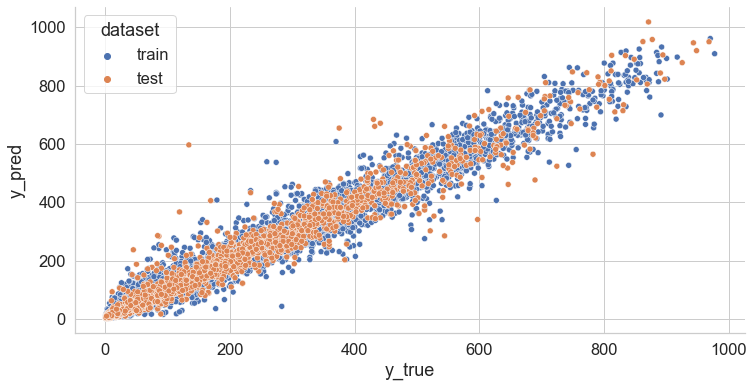

In [72]:
# Draw scatterplot of predictions vs. true values
df_res = pd.DataFrame(y_train)
df_res['y_pred']=y_pred_train
df_res['dataset']='train'
df_res.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res2 = pd.DataFrame(y_test)
df_res2['y_pred']=y_pred_test
df_res2['dataset']='test'
df_res2.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res = pd.concat([df_res, df_res2], ignore_index=True, sort=False)

#sns.relplot(x='y_true', y='y_pred', data=df_res, col='dataset', hue='dataset',height = 4)
plt.figure(figsize=(12,6))
sns.scatterplot(x='y_true', y='y_pred', hue='dataset', data=df_res)
sns.despine()


# RandomForest Regression

## Split data

In [73]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y = df_bike['count']

In [74]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size = 0.2, 
                                                            random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708,), (2178,))

## Engineer features

_Not required for RandomForest regression_

## Create model

In [75]:
rgr_rf = TransformedTargetRegressor(regressor=RandomForestRegressor(), 
                                               func=np.log1p, inverse_func=np.expm1)


In [76]:
rgr_rf.fit(X_train, y_train);

In [77]:
y_pred_train = rgr_rf.predict(X_train)
y_pred_test = rgr_rf.predict(X_test)

In [78]:
# R2 for train and test data
round(r2_score(y_train, y_pred_train),3), round(r2_score(y_test, y_pred_test),3)

(0.991, 0.951)

In [79]:
# RMSLE for train and test data
round(rmsle(y_train, y_pred_train), 3), round(rmsle(y_test, y_pred_test), 3)

(0.116, 0.302)

## Optimize hyperparameters

In [80]:
rgr_rf.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__bootstrap', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__max_samples', 'regressor__min_impurity_decrease', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_jobs', 'regressor__oob_score', 'regressor__random_state', 'regressor__verbose', 'regressor__warm_start', 'regressor', 'transformer'])

### RandomGrid

In [81]:
random_grid = {
    'regressor__n_estimators' : [50, 100, 200, 400],
    'regressor__max_depth' : [5, 10, 50, None],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],
    'regressor__min_samples_leaf' : [1, 0.05, 0.1],
    'regressor__bootstrap' : [True, False]
}

In [82]:
cv_rnd_h = RandomizedSearchCV(estimator=rgr_rf, 
                              param_distributions=random_grid,
                              scoring=rmsle_scorer,
                              n_iter=100, cv=3, n_jobs=-1,)

In [83]:
cv_rnd_h.fit(X_train, y_train);

In [84]:
# Print results of hyperparameter optimization using random search       
print_results(cv_rnd_h, False)

Best:
-0.324  for  {'regressor__n_estimators': 200, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'auto', 'regressor__max_depth': None, 'regressor__bootstrap': True}


In [85]:
rgr_rf_best = cv_rnd_h.best_estimator_

### GridSearch

In [86]:
# Define parameters for hyperparameter optimization via GridSearch
parameters = {
    'regressor__n_estimators' : [50, 100, 200, 300, 400, 500],
    'regressor__max_depth' : [5, 50, 100, None],
}

In [87]:
cv_grd_h = GridSearchCV(estimator=rgr_rf_best, 
                       param_grid=parameters, 
                       cv=3, scoring=rmsle_scorer,
                       n_jobs=-1)

In [88]:
cv_grd_h.fit(X_train, y_train);

In [89]:
# Print results of hyperparameter optimization using grid search                
print_results(cv_grd_h, True)

Best:
-0.324  for  {'regressor__max_depth': None, 'regressor__n_estimators': 300}
All:
-0.553  for {'regressor__max_depth': 5, 'regressor__n_estimators': 50}
-0.555  for {'regressor__max_depth': 5, 'regressor__n_estimators': 100}
-0.554  for {'regressor__max_depth': 5, 'regressor__n_estimators': 200}
-0.553  for {'regressor__max_depth': 5, 'regressor__n_estimators': 300}
-0.553  for {'regressor__max_depth': 5, 'regressor__n_estimators': 400}
-0.553  for {'regressor__max_depth': 5, 'regressor__n_estimators': 500}
-0.329  for {'regressor__max_depth': 50, 'regressor__n_estimators': 50}
-0.327  for {'regressor__max_depth': 50, 'regressor__n_estimators': 100}
-0.325  for {'regressor__max_depth': 50, 'regressor__n_estimators': 200}
-0.325  for {'regressor__max_depth': 50, 'regressor__n_estimators': 300}
-0.325  for {'regressor__max_depth': 50, 'regressor__n_estimators': 400}
-0.324  for {'regressor__max_depth': 50, 'regressor__n_estimators': 500}
-0.327  for {'regressor__max_depth': 100, 're

In [90]:
# Define best rf regression model (here manually based on long table of results, complexity vs. score)
rgr_rf_best = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=200, max_depth=100), 
                                               func=np.log1p, inverse_func=np.expm1)
# rgr_rf_best = cv_grd_h.best_estimator_

## Evaluate model

### Using R2

_Skipped_

### Using RMSLE

In [91]:
# Fit rgr-modell and get prediction from optimized model
rgr_rf_best.fit(X_train, y_train)
y_pred_train = rgr_rf_best.predict(X_train)
y_pred_test = rgr_rf_best.predict(X_test)

In [92]:
# With RMSLE as scorer
cross_val_rmsle = -1 * cross_val_score(rgr_rf_best, 
                                       X_train, y_train, 
                                       cv=5, scoring=rmsle_scorer,
                                       n_jobs=-1)
cross_val_rmsle

array([0.29685155, 0.3168914 , 0.32730445, 0.30557944, 0.34539577])

In [93]:
# Mean RMSLE from cross-validation and RMSLE for test data
round(cross_val_rmsle.mean(), 3), round(rmsle(y_test, y_pred_test), 3)

(0.318, 0.3)

### Check predictions vs. true values

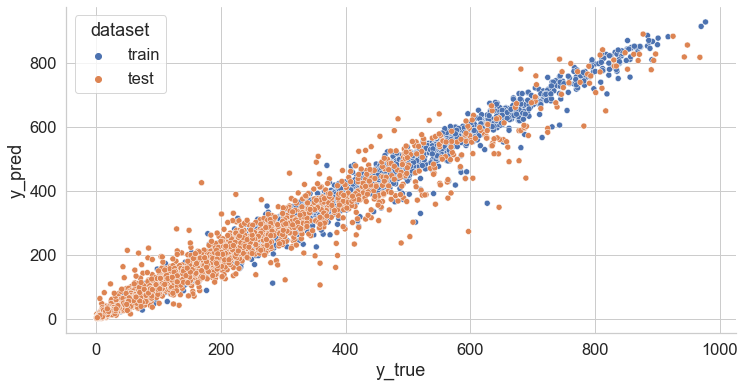

In [94]:
# Draw scatterplot of predictions vs. true values

df_res = pd.DataFrame(y_train)
df_res['y_pred']=y_pred_train
df_res['dataset']='train'
df_res.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res2 = pd.DataFrame(y_test)
df_res2['y_pred']=y_pred_test
df_res2['dataset']='test'
df_res2.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res = pd.concat([df_res, df_res2], ignore_index=True, sort=False)

#sns.relplot(x='y_true', y='y_pred', data=df_res, col='dataset', hue='dataset',height = 4)
plt.figure(figsize=(12,6))
sns.scatterplot(x='y_true', y='y_pred', hue='dataset', data=df_res)
sns.despine()

### Feature importance

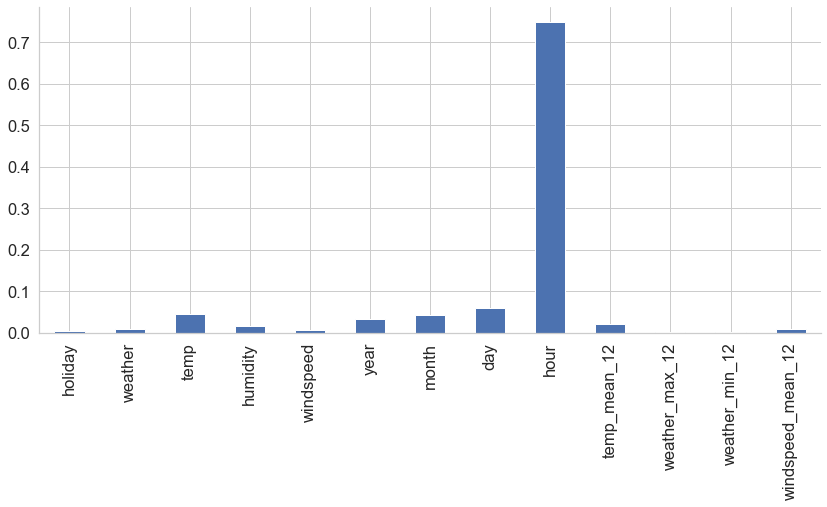

In [95]:
# Analyze feature importance
importance = pd.DataFrame(rgr_rf_best.regressor_.feature_importances_)
importance.index = X.columns
importance.sort_values(by = 0, ascending = False).head(10)

importance.plot.bar(legend=False, figsize=(14,6))
sns.despine()

# Linear Regression (separate models for casual and registered)

## Split data and transform y

In [96]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y_cas = df_bike['casual']
y_reg = df_bike['registered']
y = df_bike[['casual', 'registered', 'count']]

In [97]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708, 3), (2178, 3))

In [98]:
# Derive required target variables for 'casual' and 'registered' bike counts
y_cas_train = y_train['casual']
y_reg_train = y_train['registered']

y_cas_test = y_test['casual']
y_reg_test = y_test['registered']

y_train = y_train['count']
y_test = y_test['count']

## Engineer features

_Same feature engineering as for linear regression with one model_

## Create regression model

### Model for 'casual'

In [99]:
rgr_ln_cas = Pipeline(steps=[
    ('preprocessor', feature_transform),
    ('poly_features', PolynomialFeatures(degree=2, 
                                         include_bias=False,
                                         interaction_only=False)),
    ('m_ln_cas', LinearRegression()) 
])

rgr_ln_cas_t = TransformedTargetRegressor(regressor=rgr_ln_cas, func=np.log1p, inverse_func=np.expm1)

In [100]:
rgr_ln_cas_t.fit(X_train, y_cas_train);

In [101]:
round(rgr_ln_cas_t.score(X_train, y_cas_train), 3), round(rgr_ln_cas_t.score(X_test, y_cas_test), 3)

(0.904, 0.893)

### Model for 'registered'

In [102]:
rgr_ln_reg = Pipeline(steps=[
    ('preprocessor', feature_transform),
    ('poly_features', PolynomialFeatures(degree=2, 
                                         include_bias=False,
                                        interaction_only=False)),
    ('m_ln_reg', LinearRegression()) 
])

rgr_ln_reg_t = TransformedTargetRegressor(regressor=rgr_ln_reg, func=np.log1p, inverse_func=np.expm1)

In [103]:
rgr_ln_reg_t.fit(X_train, y_reg_train);

## Evaluate regression model

_2 metrics used (R2 & RMSLE), RMSLE used for Kaggle competition_

### Using R2 - casual counts

In [104]:
r2_train = round(rgr_ln_cas_t.score(X_train, y_cas_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.904


In [105]:
r2_test = round(rgr_ln_cas_t.score(X_test, y_cas_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.893


In [106]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_ln_cas_t, X_train, y_cas_train, 
                               cv=5, scoring='r2',
                               n_jobs=-1)
cross_val_r2

array([0.85422009, 0.8719859 , 0.87351316, 0.86944743, 0.87748992])

In [107]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.869

### Using R2 - registered counts

In [108]:
r2_train = round(rgr_ln_reg_t.score(X_train, y_reg_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.958


In [109]:
r2_test = round(rgr_ln_reg_t.score(X_test, y_reg_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.95


In [110]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_ln_reg_t, X_train, y_reg_train, 
                               cv=5, scoring='r2',
                               n_jobs=-1)
cross_val_r2

array([0.94150807, 0.93790813, 0.93451383, 0.95307043, 0.94073084])

In [111]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.942

### Using RMSLE - combined/counts

In [112]:
# Get predictions and ensure that all counts are non-negative (only for 'cas' model)
# casual
y_cas_pred_train = np.array([max(i, 0) for i in rgr_ln_cas_t.predict(X_train)])
y_cas_pred_test = np.array([max(i, 0) for i in rgr_ln_cas_t.predict(X_test)])
# registered
y_reg_pred_train = rgr_ln_reg_t.predict(X_train)
y_reg_pred_test = rgr_ln_reg_t.predict(X_test)

In [113]:
#Get predictions for train and test dataset
y_pred_train = y_cas_pred_train + y_reg_pred_train
y_pred_test = y_cas_pred_test + y_reg_pred_test

In [114]:
# RMSLE for train set
RMSLE_train = round(rmsle(y_train, y_pred_train), 3)
print(f'RMSLE for train dataset: {RMSLE_train}')

RMSLE for train dataset: 0.254


In [115]:
# RMSLE for train set
RMSLE_test = round(rmsle(y_test, y_pred_test), 3)
print(f'RMSLE for test dataset: {RMSLE_test}')

RMSLE for test dataset: 0.288


In [116]:
# Random cross-validation of combined model

# Make sure to use original train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rmsle_list = []

for i in [12, 24, 44, 233, 53]:
    
    #Split the data set
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
    
    y_cas_trn = y_trn['casual']
    y_reg_trn = y_trn['registered']

    y_cas_tst = y_tst['casual']
    y_reg_tst = y_tst['registered']

    y_tst = y_tst['count']
    
    # Train the 2 models
    rgr_ln_cas_t.fit(X_trn, y_cas_trn)
    rgr_ln_reg_t.fit(X_trn, y_reg_trn)
    
    # Predict outcomes separately
    # ...casual counts
    y_cas_pred_tst = np.array([max(i, 0) for i in rgr_ln_cas_t.predict(X_tst)])
    # ...registered counts
    y_reg_pred_tst = rgr_ln_reg_t.predict(X_tst)
    
    # Combine predictions
    y_pred_tst = y_cas_pred_tst + y_reg_pred_tst

    # Calculate RMSLE score
    rmsle_i = rmsle(y_tst, y_pred_tst)
    
    # Save result
    rmsle_list.append(rmsle_i)
    
# Reset y_train values
y_train = y_train['count']
y_test = y_test['count']
    
# Print results
print('List of results: ', [round(i, 3) for i in rmsle_list])
print('Mean value: ', round(np.mean(rmsle_list), 3))

List of results:  [0.308, 0.31, 0.295, 0.3, 0.298]
Mean value:  0.302


### Check predictions vs. true values

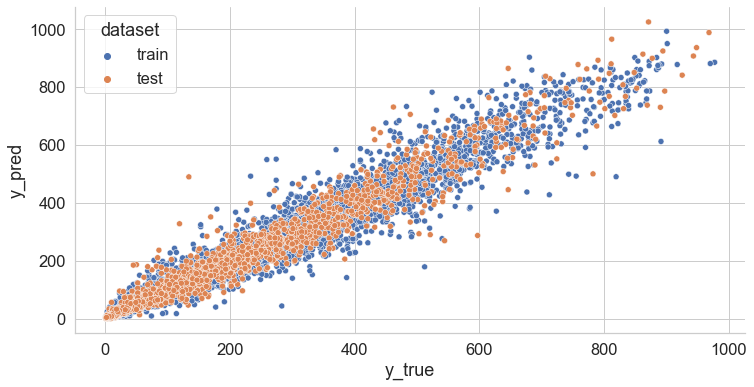

In [117]:
# Draw scatterplot of predictions vs. true values

df_res = pd.DataFrame(y_train)
df_res['y_pred']=y_pred_train
df_res['dataset']='train'
df_res.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res2 = pd.DataFrame(y_test)
df_res2['y_pred']=y_pred_test
df_res2['dataset']='test'
df_res2.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res = pd.concat([df_res, df_res2], ignore_index=True, sort=False)

#sns.relplot(x='y_true', y='y_pred', data=df_res, col='dataset', hue='dataset',height = 4)
plt.figure(figsize=(12,6))
sns.scatterplot(x='y_true', y='y_pred', hue='dataset', data=df_res)
sns.despine()


# RandomForest (separate models for casual and registered)

## Split data and transform y

In [118]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y_cas = df_bike['casual']
y_reg = df_bike['registered']
y = df_bike[['casual', 'registered', 'count']]

In [119]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708, 3), (2178, 3))

In [120]:
# Derive required target variables for 'casual' and 'registered' bike counts
y_cas_train = y_train['casual']
y_reg_train = y_train['registered']

y_cas_test = y_test['casual']
y_reg_test = y_test['registered']

y_train = y_train['count']
y_test = y_test['count']

## Engineer features

_Same feature engineering as for linear regression with one model_

## Create regression model

### Model for 'casual'

In [121]:
rgr_rf_cas_t = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=200, max_depth=20), 
                                          func=np.log1p, inverse_func=np.expm1)

In [122]:
rgr_rf_cas_t.fit(X_train, y_cas_train);

In [123]:
round(rgr_rf_cas_t.score(X_train, y_cas_train), 3), round(rgr_rf_cas_t.score(X_test, y_cas_test), 3)

(0.983, 0.924)

### Model for 'registered'

In [124]:
rgr_rf_reg_t = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=200, max_depth=20),
                                          func=np.log1p, inverse_func=np.expm1)

In [125]:
rgr_rf_reg_t.fit(X_train, y_reg_train);

In [126]:
round(rgr_rf_reg_t.score(X_train, y_reg_train), 3), round(rgr_rf_reg_t.score(X_test, y_reg_test), 3)

(0.992, 0.956)

## Optimize hyperparameters

### Define parameters for the grid search

In [127]:
# Define parameters for hyperparameter optimization via GridSearch
parameters = {
    'regressor__n_estimators' : [50, 100, 400],
    'regressor__max_depth' : [5, 15, None],
    'regressor__max_features': ['auto', 'sqrt', 2],
    'regressor__min_samples_leaf' : [1, 2, 4],
}

### Model for 'casual'

In [128]:
cv_grd_h = GridSearchCV(estimator=rgr_rf_cas_t, 
                       param_grid=parameters, 
                       cv=3, scoring=rmsle_scorer,
                       n_jobs=-1)

In [129]:
cv_grd_h.fit(X_train, y_cas_train);

In [130]:
# Print results of hyperparameter optimization using grid search                
print_results(cv_grd_h, True)

Best:
-0.491  for  {'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 400}
All:
-0.643  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}
-0.644  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}
-0.642  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 400}
-0.642  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 50}
-0.644  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 100}
-0.641  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 400}


In [131]:
rgr_rf_cas_best = cv_grd_h.best_estimator_

### Model for registered

In [132]:
cv_grd_h = GridSearchCV(estimator=rgr_rf_reg_t, 
                       param_grid=parameters, 
                       cv=3, scoring=rmsle_scorer,
                       n_jobs=-1)

In [133]:
cv_grd_h.fit(X_train, y_reg_train);

In [134]:
# Print results of hyperparameter optimization using grid search                
print_results(cv_grd_h, True)

Best:
-0.315  for  {'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 400}
All:
-0.555  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}
-0.555  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}
-0.555  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 400}
-0.558  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 50}
-0.555  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 100}
-0.554  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 400}


In [135]:
# Define best rf regression model (also based on long table of results, complexity vs. score)
rgr_rf_reg_best = cv_grd_h.best_estimator_

## Evaluate regression model

_2 metrics used (R2 & RMSLE), RMSLE used for Kaggle competition_

### Using R2 - casual counts

In [136]:
r2_train = round(rgr_rf_cas_best.score(X_train, y_cas_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.976


In [137]:
r2_test = round(rgr_rf_cas_best.score(X_test, y_cas_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.922


In [138]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_rf_cas_best, X_train, y_cas_train, 
                               cv=5, scoring='r2',
                               n_jobs=-1)
cross_val_r2

array([0.92133829, 0.90907375, 0.9045265 , 0.91819623, 0.89325671])

In [139]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.909

### Using R2 - registered counts

In [140]:
r2_train = round(rgr_rf_reg_best.score(X_train, y_reg_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.992


In [141]:
r2_test = round(rgr_rf_reg_best.score(X_test, y_reg_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.956


In [142]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_rf_reg_best, X_train, y_reg_train, 
                               cv=5, scoring='r2',
                               n_jobs=-1)
cross_val_r2

array([0.95528349, 0.94406067, 0.94153671, 0.94910753, 0.93759899])

In [143]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.946

### Using RMSLE - combined/counts

In [144]:
# Get predictions and ensure that all counts are non-negative (only for 'cas' model)
# casual
y_cas_pred_train = np.array([max(i, 0) for i in rgr_rf_cas_best.predict(X_train)])
y_cas_pred_test = np.array([max(i, 0) for i in rgr_rf_cas_best.predict(X_test)])
# registered
y_reg_pred_train = rgr_rf_reg_best.predict(X_train)
y_reg_pred_test = rgr_rf_reg_best.predict(X_test)

In [145]:
#Get predictions for train and test dataset
y_pred_train = y_cas_pred_train + y_reg_pred_train
y_pred_test = y_cas_pred_test + y_reg_pred_test

In [146]:
# RMSLE for train set
RMSLE_train = round(rmsle(y_train, y_pred_train), 3)
print(f'RMSLE for train dataset: {RMSLE_train}')

RMSLE for train dataset: 0.119


In [147]:
# RMSLE for train set
RMSLE_test = round(rmsle(y_test, y_pred_test), 3)
print(f'RMSLE for test dataset: {RMSLE_test}')

RMSLE for test dataset: 0.292


In [148]:
# Random cross-validation of combined model

# Make sure to use original train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rmsle_list = []

for i in [12, 24, 44, 233, 53]:
    
    #Split the data set
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
    
    y_cas_trn = y_trn['casual']
    y_reg_trn = y_trn['registered']

    y_cas_tst = y_tst['casual']
    y_reg_tst = y_tst['registered']

    y_tst = y_tst['count']
    
    # Train the 2 models
    rgr_rf_cas_best.fit(X_trn, y_cas_trn)
    rgr_rf_reg_best.fit(X_trn, y_reg_trn)
    
    # Predict outcomes separately
    # ...casual counts
    y_cas_pred_tst = np.array([max(i, 0) for i in rgr_rf_cas_best.predict(X_tst)])
    # ...registered counts
    y_reg_pred_tst = rgr_rf_reg_best.predict(X_tst)
    
    # Combine predictions
    y_pred_tst = y_cas_pred_tst + y_reg_pred_tst

    # Calculate RMSLE score
    rmsle_i = rmsle(y_tst, y_pred_tst)
    
    # Save result
    rmsle_list.append(rmsle_i)
    
# Reset y_train values
y_train = y_train['count']
y_test = y_test['count']
    
# Print results
print('List of results: ', [round(i, 3) for i in rmsle_list])
print('Mean value: ', round(np.mean(rmsle_list), 3))

List of results:  [0.305, 0.319, 0.31, 0.313, 0.304]
Mean value:  0.31


### Check predictions vs. true values

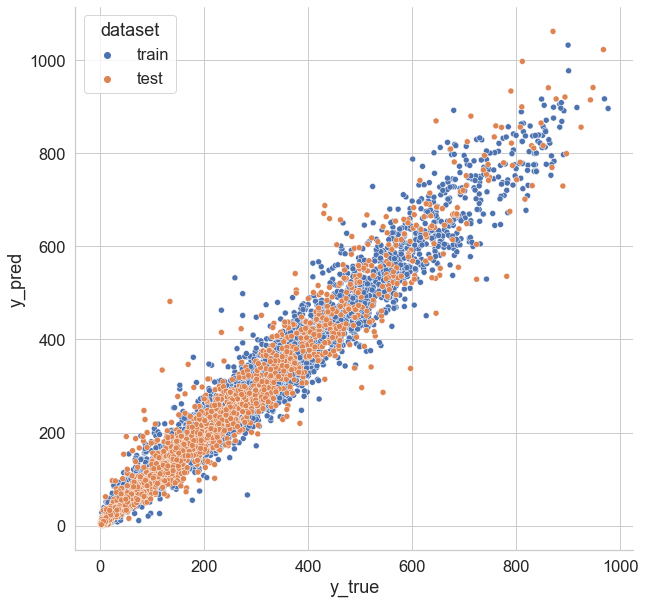

In [186]:
# Draw scatterplot of predictions vs. true values

df_res = pd.DataFrame(y_train)
df_res['y_pred']=y_pred_train
df_res['dataset']='train'
df_res.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res2 = pd.DataFrame(y_test)
df_res2['y_pred']=y_pred_test
df_res2['dataset']='test'
df_res2.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res = pd.concat([df_res, df_res2], ignore_index=True, sort=False)

#sns.relplot(x='y_true', y='y_pred', data=df_res, col='dataset', hue='dataset',height = 4)
plt.figure(figsize=(10,10))
sns.scatterplot(x='y_true', y='y_pred', hue='dataset', data=df_res)
sns.despine()

f_name = '../images/rdf_2_model_approach.png'
plt.savefig(f_name, dpi = 250, transparent=True)

# Linear Regression and Random Forest sequentially combined

## Split the data

In [150]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y = df_bike['count']

In [151]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708,), (2178,))

## Engineer features

### Define pipelines

_Pipelines can be reused_

### Summarize in column transformer

In [152]:
# Defining the "preprocessor" (using only 'timestamp related' data)
time_feature_transform = ColumnTransformer([
    ('one_hot_encoding', cat_pipe, ['year', 'month', 'day', 'hour']),
])

## Create and fit models

In [153]:
# Create linear regression model
rgr_lns = Pipeline(steps=[
            ('preprocessor', time_feature_transform),
            ('poly_features', PolynomialFeatures(degree=2, 
                                                 include_bias=False, 
                                                 interaction_only=False)),
            ('m_ln', LinearRegression())
])

rgr_lns_t = TransformedTargetRegressor(regressor=rgr_ln, func=np.log1p, inverse_func=np.expm1)

In [154]:
rgr_rfs = RandomForestRegressor(n_estimators=400, max_depth=10)

#rgr_rfs_t = TransformedTargetRegressor(regressor=RandomForestRegressor(), 
                                               #func=np.log1p, inverse_func=np.expm1)

In [155]:
rgr_lns_t.fit(X_train, y_train);

In [156]:
y_lns_pred_train = rgr_lns_t.predict(X_train)

In [157]:
y_rfs_train = y_train - y_lns_pred_train

In [158]:
rgr_rfs.fit(X_train, y_rfs_train)

RandomForestRegressor(max_depth=10, n_estimators=400)

In [159]:
y_rfs_pred_train = rgr_rfs.predict(X_train)

In [160]:
y_pred_train = y_lns_pred_train + y_rfs_pred_train
y_pred_train = [max(i, 0) for i in y_pred_train]

In [161]:
r2_score(y_train, y_pred_train)

0.9711320580190343

In [162]:
rmsle(y_train, y_pred_train)

0.26085223220678105

In [163]:
y_lns_pred_test = rgr_lns_t.predict(X_test)

In [164]:
y_rfs_pred_test = rgr_rfs.predict(X_test)

In [165]:
y_pred_test = [max(i, 0) for i in (y_lns_pred_test + y_rfs_pred_test)]

In [166]:
r2_score(y_test, y_pred_test)

0.9525640788302947

In [167]:
rmsle(y_test, y_pred_test)

0.3043690722410502

### Tune hyperparameters of randomforest model

_Currently done manually - automation to be added_

## Evaluate model

In [168]:
# Random cross-validation of combined model

rmsle_list = []

for i in [12, 24, 44, 233, 53]:
    
    #Split the data set
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
    
    # Train linear model
    rgr_lns_t.fit(X_trn, y_trn)
    
    # Predict outcomes of linear model
    y_lns_pred_trn = rgr_lns_t.predict(X_trn)
    
    # Transform target variable for randomforest
    y_rfs_trn = y_trn - y_lns_pred_trn
    
    # Train RandomForest model
    rgr_rfs.fit(X_trn, y_rfs_trn)
    
    # Predict test data with linear model
    y_lns_pred_tst = rgr_lns_t.predict(X_tst)
        
    # Predict deviations with RandomForest
    y_rfs_pred_tst = rgr_rfs.predict(X_tst)
    
    # Combine model results
    y_pred_tst = [max(i, 0) for i in (y_lns_pred_tst + y_rfs_pred_tst)]
    
    # Calculate rmsle
    rmsle_i = rmsle(y_tst, y_pred_tst)
    
    # Save result in list
    rmsle_list.append(rmsle_i)
    
# Print results
print('List of results: ', [round(i, 3) for i in rmsle_list])
print('Mean value: ', round(np.mean(rmsle_list), 3))

List of results:  [0.344, 0.343, 0.317, 0.339, 0.309]
Mean value:  0.33


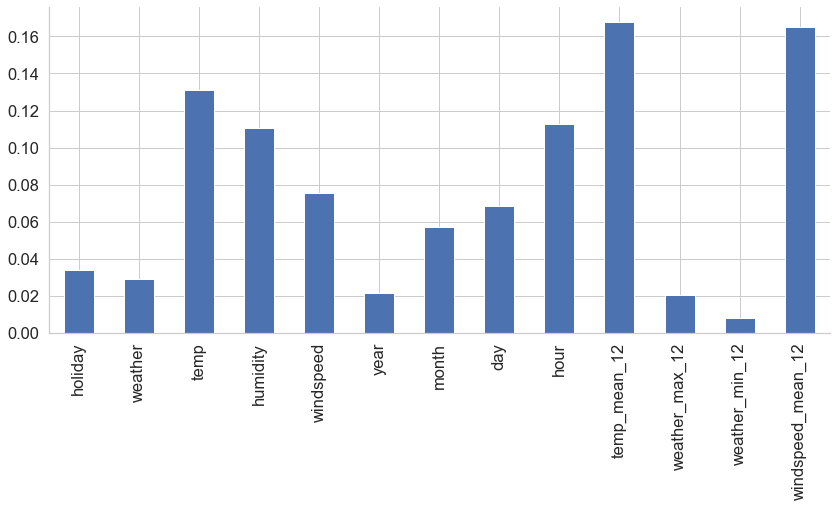

In [169]:
# Analyze feature importance
importance = pd.DataFrame(rgr_rfs.feature_importances_)
importance.index = X.columns
importance.sort_values(by = 0, ascending = False).head(10)

importance.plot.bar(legend=False, figsize=(14,6))
sns.despine()

# Submission to Kaggle

## Import data

In [170]:
# Get test.data
X_test_kaggle = pd.read_csv('/Users/philipwitte/Documents/spiced_projects/fenugreek-student-code/week03/data/test.csv', 
                            index_col=0,
                            parse_dates=True)
X_test_kaggle.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [171]:
X_test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 456.5 KB


## Add additional features

### Add time related features

In [172]:
X_test_kaggle = X_test_kaggle.reset_index()

In [173]:
# Year
X_test_kaggle['year'] = X_test_kaggle['datetime'].apply(lambda x: x.year)

In [174]:
# Month
X_test_kaggle['month'] = X_test_kaggle['datetime'].apply(lambda x: x.month)

In [175]:
# Day of the week
X_test_kaggle['day'] = X_test_kaggle['datetime'].apply(lambda x: x.isoweekday())

In [176]:
# Hour within day
X_test_kaggle['hour'] = X_test_kaggle['datetime'].apply(lambda x: x.hour)

In [177]:
X_test_kaggle = X_test_kaggle.set_index('datetime')

### Add 'rolling' mean/min/max features

In [178]:
# mean of temp of previous 3 and 12 hours
X_test_kaggle['temp_mean_12'] = X_test_kaggle['temp'].rolling(12).mean().fillna(method='bfill')

In [179]:
# max of weather of previous 3 and 12 hours
X_test_kaggle['weather_max_12'] = X_test_kaggle['weather'].rolling(12).max().fillna(method='bfill')

In [180]:
# min of weather of previous 3 and 12 hours
X_test_kaggle['weather_min_12'] = X_test_kaggle['weather'].rolling(12).min().fillna(method='bfill')

In [181]:
# mean of wind of previous 3 and 12 hours
X_test_kaggle['windspeed_mean_12'] = X_test_kaggle['windspeed'].rolling(12).mean().fillna(method='bfill')

### Drop correlated columns

In [182]:
X_test_kaggle = X_test_kaggle.drop(['workingday', 'season', 'atemp'], axis = 1)

### Check data

In [183]:
X_test_kaggle.head(3)

,holiday,weather,temp,humidity,windspeed,year,month,day,hour,temp_mean_12,weather_max_12,weather_min_12,windspeed_mean_12
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,0,1,10.66,56,26.0027,2011,1,4,0,10.181667,2.0,1.0,13.167733
2011-01-20 01:00:00,0,1,10.66,56,0.0000,2011,1,4,1,10.181667,2.0,1.0,13.167733
2011-01-20 02:00:00,0,1,10.66,56,0.0000,2011,1,4,2,10.181667,2.0,1.0,13.167733


## Predict count

In [184]:
# Predict and merge the data
# Current classifier used: LinearRegression
y_pred_kaggle = rgr_ln_t.predict(X_test_kaggle)
y_pred_kaggle = X_test_kaggle.reset_index()[['datetime']].join(pd.DataFrame(y_pred_kaggle, columns = ['count']))
y_pred_kaggle.set_index('datetime', inplace = True)
y_pred_kaggle

,count
datetime,
2011-01-20 00:00:00,10.056425
2011-01-20 01:00:00,4.932642
2011-01-20 02:00:00,3.181455
2011-01-20 03:00:00,1.838085
2011-01-20 04:00:00,1.664527
...,...
2012-12-31 19:00:00,369.631131
2012-12-31 20:00:00,255.385815
2012-12-31 21:00:00,214.786555


In [185]:
y_pred_kaggle.to_csv('submission.csv')